In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim import Adam


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Set random seed for reproducibility
torch.manual_seed(44)
np.random.seed(44)


# ---- nets (same API you had) ----
class PressureHeadNet(nn.Module):
    def __init__(self, hidden_dim, num_layers):
        super().__init__()
        layers = [nn.Linear(2, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers += [nn.Linear(hidden_dim, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, z_star, t_star):
        return self.net(torch.cat([z_star, t_star], dim=1))


class WaterTableNet(nn.Module):
    def __init__(self, hidden_dim, num_layers, eps=1e-3):
        super().__init__()
        layers = [nn.Linear(1, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers += [nn.Linear(hidden_dim, 1)]
        self.net = nn.Sequential(*layers)
        self.eps = eps

    def forward(self, t_star):
        return F.softplus(self.net(t_star)) + self.eps  # z_b* > 0


# ---- dimensionless van Genuchten ----
class VanGenuchtenStar:
    """
    Starred (dimensionless) van Genuchten relations.
    Returns:
      Theta(h*): effective saturation S_e in (0, 1)
      Ktilde(h*): dimensionless conductivity in (eps, 1]
    """

    def __init__(self, theta_s, theta_r, n, l, eps=1e-8, smooth=False, delta=1e-3):
        # store scalars; cast to tensor later to match h_star dtype/device
        self.theta_s = float(theta_s)
        self.theta_r = float(theta_r)
        self.n = float(n)
        self.m = 1.0 - 1.0 / float(n)
        self.l = float(l)
        self.eps = float(eps)  # clamp margin
        self.smooth = bool(smooth)  # optional smooth switch at h*=0
        self.delta = float(delta)  # smoothness width for sigmoid

    def _one(self, x):  # helper to make 1.0 like x
        return torch.ones_like(x)

    def _eps_like(self, x):
        # tie eps to dtype precision a bit
        base = self.eps
        if x.dtype == torch.float32:
            base = max(base, 1e-6)
        return torch.as_tensor(base, dtype=x.dtype, device=x.device)

    def Theta(self, h_star):
        """
        Effective saturation S_e(h*) in (eps, 1-eps) with safe clamps.
        S_e = [1 + |h*|^n]^(-m) for h*<0, else 1.
        """
        n, m = self.n, self.m
        eps = self._eps_like(h_star)

        # unsaturated branch
        abs_h = torch.abs(h_star)
        Se_unsat = torch.pow(1.0 + torch.pow(abs_h, n), -m)
        # clamp strictly inside (0,1)
        Se_unsat = torch.clamp(Se_unsat, eps, 1.0 - eps)

        if self.smooth:
            # soft switch to avoid a hard branch at h*=0
            s = torch.sigmoid(h_star / self.delta)  # ~0 for h*<<0, ~1 for h*>>0
            Se = Se_unsat * (1.0 - s) + s * self._one(h_star)  # blend to 1
        else:
            Se = torch.where(h_star < 0.0, Se_unsat, self._one(h_star))

        # final guard
        return torch.clamp(Se, eps, 1.0 - eps)

    def Ktilde(self, h_star):
        """
        Dimensionless conductivity K~(h*) in (eps, 1].
        K~ = S_e^l * [1 - (1 - S_e^(1/m))^m]^2, saturated = 1.
        """
        m, l = self.m, self.l
        eps = self._eps_like(h_star)

        Se = self.Theta(h_star)  # already clamped (eps, 1-eps)
        Se_mroot = torch.pow(Se, 1.0 / m)  # S_e^(1/m)  ∈ (eps^(1/m), 1-eps^(1/m))
        inner = 1.0 - Se_mroot  # in (0,1)
        term = 1.0 - torch.pow(inner, m)  # in (0,1]
        K_unsat = torch.pow(Se, l) * torch.pow(term, 2.0)
        K_unsat = torch.clamp(K_unsat, eps, 1.0)

        if self.smooth:
            s = torch.sigmoid(h_star / self.delta)
            Kt = K_unsat * (1.0 - s) + s * self._one(h_star)
        else:
            Kt = torch.where(h_star < 0.0, K_unsat, self._one(h_star))

        return torch.clamp(Kt, eps, 1.0)


# ---- NON-DIMENSIONAL PINN (complete) ----
class RichardsPINN(nn.Module):
    """
    Internals are non-dimensional. Public methods accept dimensional (z [m], t [s]).
    """

    def __init__(
        self,
        soil_params,
        q0_data,
        Sy,
        zr,
        h_net_config,
        zb_net_config,
        zb_initial=1.5,
        device=None,
    ):
        super().__init__()
        self.device = (
            device
            if device is not None
            else (
                torch.device("cuda")
                if torch.cuda.is_available()
                else torch.device("cpu")
            )
        )

        # Nets (operate on starred inputs)
        self.h_net = PressureHeadNet(
            h_net_config["hidden_dim"], h_net_config["num_layers"]
        ).to(self.device)
        self.zb_net = WaterTableNet(
            zb_net_config["hidden_dim"], zb_net_config["num_layers"]
        ).to(self.device)

        # Soil & scales
        theta_s = soil_params["theta_s"]
        theta_r = soil_params["theta_r"]
        alpha = soil_params["alpha"]
        n = soil_params["n"]
        Ks = soil_params["Ks"]
        l = soil_params["l"]

        self.theta_s, self.theta_r = float(theta_s), float(theta_r)
        self.dtheta = self.theta_s - self.theta_r
        self.alpha = float(alpha)  # [1/m]
        self.Ks = float(Ks)  # [m/s]

        # Choose L = zr
        self.L = float(zr)  # [m]
        self.H = 1.0 / self.alpha  # [m]
        self.T = self.dtheta * (self.L) / self.Ks  # [s]
        self.Q = Ks  # [m/s]

        # Dimensionless groups
        self.lambda_ = self.H / self.L  # = 1/(αL)
        self.Sy = torch.tensor(Sy, device=self.device, dtype=torch.float32)
        self.beta = (self.dtheta * self.L) / float(Sy)

        # Dimensionless soil relations (α*=1, Ks*=1)
        self.soil_star = VanGenuchtenStar(self.theta_s, self.theta_r, n, l)

        # Forcing (convert to starred once)
        t_arr = torch.tensor(q0_data[0], dtype=torch.float32)
        q_arr = torch.tensor(q0_data[1], dtype=torch.float32)
        self.q0_t_star = (t_arr / self.T).to(self.device).view(-1)
        self.q0_star = (q_arr / self.Q).to(self.device).view(-1)

        # IC (dimensional depth; used to form a starred target)
        self.zb_initial_dim = float(zb_initial)

    # ---------- helpers ----------
    def _to_star(self, z, t):
        return (z / self.L, t / self.T)

    def _interp_q0_star(self, t_star):
        t_flat = t_star.flatten()
        out = torch.zeros_like(t_flat)
        for i in range(len(t_flat)):
            tv = t_flat[i]
            if tv <= self.q0_t_star[0]:
                out[i] = self.q0_star[0]
            elif tv >= self.q0_t_star[-1]:
                out[i] = self.q0_star[-1]
            else:
                idx = torch.searchsorted(self.q0_t_star, tv)
                t1, t2 = self.q0_t_star[idx - 1], self.q0_t_star[idx]
                q1, q2 = self.q0_star[idx - 1], self.q0_star[idx]
                a = (tv - t1) / (t2 - t1)
                out[i] = q1 + a * (q2 - q1)
        return out.reshape_as(t_star)

    def forward(self, z, t):
        z_star, t_star = self._to_star(z, t)
        return self.forward_star(z_star, t_star)

    def forward_star(self, z_star, t_star):
        h_star = self.h_net(z_star, t_star)
        zb_star = self.zb_net(t_star)
        return h_star, zb_star

    def _derivs_star(self, h_star, z_star, t_star):
        Theta = self.soil_star.Theta(h_star)
        dTheta_dtstar = torch.autograd.grad(
            Theta.sum(), t_star, create_graph=True, retain_graph=True
        )[0]
        dhdz_star = torch.autograd.grad(
            h_star.sum(), z_star, create_graph=True, retain_graph=True
        )[0]
        Ktilde = self.soil_star.Ktilde(h_star)
        q_star = -Ktilde * (1.0 + self.lambda_ * dhdz_star)
        dqdz_star = torch.autograd.grad(
            q_star.sum(), z_star, create_graph=True, retain_graph=True
        )[0]
        return dTheta_dtstar, dqdz_star, q_star, Ktilde, dhdz_star

    def root_uptake_star(self, z):
        # Your simple box uptake S(z) with S_max [1/s], then S~ = (T/Δθ) S
        S_max = 1e-7
        S_dim = torch.where(
            z >= -self.L, torch.full_like(z, S_max), torch.zeros_like(z)
        )
        return (self.T / self.dtheta) * S_dim

    # ---------- residuals (ALL EXIST & use starred grads correctly) ----------
    def pde_residual(self, z, t):
        z_star = (z / self.L).requires_grad_(True)
        t_star = (t / self.T).requires_grad_(True)
        h_star, _ = self.forward_star(z_star, t_star)
        dTheta_dtstar, dqdz_star, _, _, _ = self._derivs_star(h_star, z_star, t_star)
        S_star = self.root_uptake_star(z)  # returns dimensionless
        return dTheta_dtstar + dqdz_star + S_star

    def surface_bc_residual(self, t):
        z0 = torch.zeros_like(t, device=t.device)
        z_star0 = (z0 / self.L).requires_grad_(True)
        t_star = (t / self.T).requires_grad_(True)
        h0_star, _ = self.forward_star(z_star0, t_star)
        _, _, q_star, _, _ = self._derivs_star(h0_star, z_star0, t_star)
        q0_star = self._interp_q0_star(t_star)
        return q_star - q0_star

    def water_table_head_residual(self, t):
        t_star = (t / self.T).requires_grad_(True)
        zb_star = self.zb_net(t_star)
        z_wt_star = -zb_star  # keep in graph
        h_wt_star, _ = self.forward_star(z_wt_star, t_star)
        return h_wt_star  # should be ~0

    def water_table_kinematic_residual(self, t):
        t_star = (t / self.T).requires_grad_(True)
        zb_star = self.zb_net(t_star)
        dzb_dtstar = torch.autograd.grad(zb_star.sum(), t_star, create_graph=True)[0]
        z_wt_star = (-zb_star).requires_grad_(True)
        h_wt_star, _ = self.forward_star(z_wt_star, t_star)
        _, _, q_star_wt, _, _ = self._derivs_star(h_wt_star, z_wt_star, t_star)
        return dzb_dtstar + self.beta * q_star_wt

    def initial_conditions_residual(self, z, t0):
        z_star = (z / self.L).requires_grad_(True)
        t0_star = (t0 / self.T).requires_grad_(True)
        h_star, zb_star = self.forward_star(z_star, t0_star)
        z_b0_star = torch.full_like(zb_star, self.zb_initial_dim / self.L)
        # Hydrostatic guess: h* = α z + (1/λ) z_b*(0)
        h_ic_star = z_star + (1.0 / self.lambda_) * z_b0_star
        return (h_star - h_ic_star), (zb_star - z_b0_star)


Using device: cpu


In [5]:




def train_pinn_original(
    soil_params,
    q0_data,
    Sy,
    zr,
    h_net_config,
    zb_net_config,
    n_epochs=1000,
    learning_rate=1e-3,
    zb_initial=1.5,
):
    """
    Train the Richards PINN (model is non-dimensional internally; trainer uses dimensional (z,t)).
    """
    # --- model & optimizer ---
    model = RichardsPINN(
        soil_params, q0_data, Sy, zr, h_net_config, zb_net_config, zb_initial
    ).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # --- time bounds from q0_data (dimensional) ---
    q0_times_t = torch.tensor(q0_data[0], dtype=torch.float32, device=device).view(
        -1, 1
    )
    t_min = float(q0_times_t.min().item())
    t_max = float(q0_times_t.max().item())
    z_max = 0.0  # surface at z = 0

    def shuffled_q0_times():
        idx = torch.randperm(q0_times_t.shape[0], device=device)
        return q0_times_t[idx].clone()

    # --- book-keeping ---
    losses = []
    comps = {
        "pde": [],
        "surf": [],
        "wt_head": [],
        "wt_kin": [],
        "ic_h": [],
        "ic_zb": [],
    }

    print(f"Training for {n_epochs} epochs | lr={learning_rate}")
    print(
        f"Time domain from q0: t∈[{t_min:.3f}, {t_max:.3f}], z adaptive in [-z_b(t), 0]"
    )

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # ===== Sample training points (adaptive domain) =====
        # (1) PDE collocation: use as many times as q0 has, shuffled each epoch
        t_col = shuffled_q0_times().requires_grad_(True)  # dimensional (N,1)

        # Predict zb(t) in DIMENSIONAL units (do NOT call zb_net on dimensional t)
        with torch.no_grad():
            # If you added model.zb_dim(t), prefer that; otherwise use T,L directly:
            # zb_hat = model.zb_dim(t_col)
            zb_hat_star = model.zb_net(t_col / model.T)  # t* = t/T
            zb_hat = model.L * zb_hat_star  # z_b = L z_b*
            # Ensure positivity already handled by net’s softplus

        # Sample z uniformly between -zb(t) and 0 for each t (dimensional)
        u_col = torch.rand_like(t_col)
        z_col = -zb_hat * (1.0 - u_col) + z_max * u_col
        z_col = z_col.detach().requires_grad_(True)

        # (2) Boundary (surface flux at z=0): times aligned to q0 support & count
        t_bc = shuffled_q0_times().requires_grad_(True)

        # (3) Initial condition (at t = t_min)
        t_ic = torch.full_like(q0_times_t, t_min)  # dimensional
        with torch.no_grad():
            # zb0 = model.zb_dim(t_ic)
            zb0_star = model.zb_net(t_ic / model.T)
            zb0 = model.L * zb0_star
        u_ic = torch.rand_like(t_ic)
        z_ic = -zb0 * (1.0 - u_ic) + z_max * u_ic  # z in [-zb(t_min), 0], dimensional

        # ===== Compute residuals (all accept dimensional inputs; convert internally) =====
        res_pde = model.pde_residual(z_col, t_col)
        loss_pde = (res_pde**2).mean()

        res_surf = model.surface_bc_residual(t_bc)
        loss_surf = (res_surf**2).mean()

        res_wt_head = model.water_table_head_residual(t_bc)
        loss_wt_head = (res_wt_head**2).mean()

        res_wt_kin = model.water_table_kinematic_residual(t_bc)
        loss_wt_kin = (res_wt_kin**2).mean()

        res_ic_h, res_ic_zb = model.initial_conditions_residual(z_ic, t_ic)
        loss_ic_h = (res_ic_h**2).mean()
        loss_ic_zb = (res_ic_zb**2).mean()

        w_surf = 1.0
        w_wt_h = 0.01
        w_wt_kin = 1000.0
        w_ic_h = 0.1
        w_ic_zb = 10.0
        w_pde = 1000  # smooth ramp

        total_loss = (
            w_pde * loss_pde
            + w_surf * loss_surf
            + w_wt_h * loss_wt_head * 0
            + w_wt_kin * loss_wt_kin * 0
            + w_ic_h * loss_ic_h * 0
            + w_ic_zb * loss_ic_zb * 0
        )



        # ===== Backprop + step =====
        total_loss.backward()
        optimizer.step()

        # ===== Logging =====
        losses.append(total_loss.item())
        comps["pde"].append(loss_pde.item())
        comps["surf"].append(loss_surf.item())
        comps["wt_head"].append(loss_wt_head.item())
        comps["wt_kin"].append(loss_wt_kin.item())
        comps["ic_h"].append(loss_ic_h.item())
        comps["ic_zb"].append(loss_ic_zb.item())

        if (epoch + 1) % 200 == 0 or epoch == 0:
            print(
                f"[{epoch + 1:4d}/{n_epochs}] "
                f"total={total_loss.item():.3e} | "
                f"PDE={loss_pde.item():.3e}, Surf={loss_surf.item():.3e}, "
                f"WT(h)={loss_wt_head.item():.3e}, WT(kin)={loss_wt_kin.item():.3e}, "
                f"IC(h)={loss_ic_h.item():.3e}, IC(zb)={loss_ic_zb.item():.3e}"
            )

    print("Training done.")
    return model, losses, comps





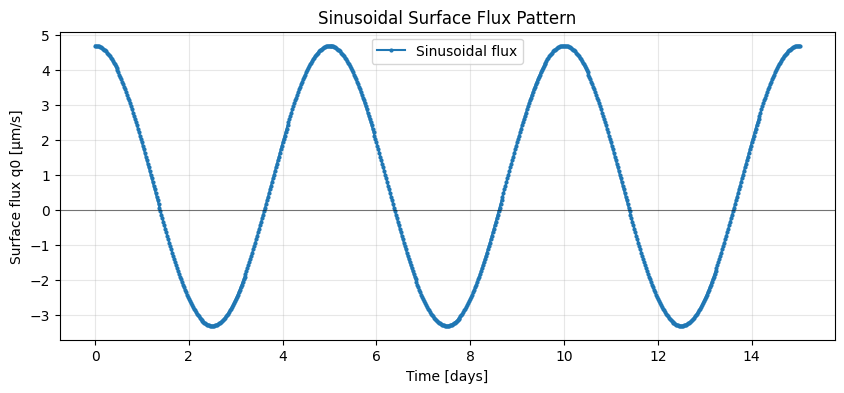

Flux range: -3.30 to 4.70 μm/s
Period: 5 days, Total duration: 15 days


In [6]:
import numpy as np
import matplotlib.pyplot as plt


def create_sinusoidal_qflux(
    total_days=15,
    dt_minutes=30,
    amplitude=4e-6,
    period_days=5,
    mean_flux=1e-7,
    phase_shift=0,
):
    """
    Create sinusoidal surface flux pattern.

    Returns:
        times_days (np.ndarray): time vector in days
        qflux (np.ndarray): flux in m/s (positive = evaporation, negative = infiltration)
    """
    dt_days = dt_minutes / (24 * 60)
    times_days = np.arange(0, total_days + dt_days, dt_days)

    # Sinusoidal flux: q(t) = mean + amplitude * sin(2π*t/period + phase)
    omega = 2 * np.pi / period_days  # angular frequency [rad/day]
    qflux = mean_flux + amplitude * np.sin(omega * times_days + phase_shift)
    return times_days, qflux


# Create sinusoidal q0_data (time in days, flux in m/s)
times_sin_days, qflux_sin = create_sinusoidal_qflux(
    total_days=15,
    amplitude=4e-6,  # 4 μm/s amplitude
    period_days=5,  # 5-day cycle
    mean_flux=7e-7,  # slight evaporation on average
    phase_shift=np.pi / 2,  # start at peak
)

# Convert time from days -> seconds (model expects seconds)
times_sin_sec = (times_sin_days * 24 * 60 * 60).astype(np.float32)

# Pack for the model (time in seconds, flux in m/s)
q0_data_sin = (times_sin_sec.tolist(), qflux_sin.astype(np.float32).tolist())

# Plot the sinusoidal flux (in days and μm/s for readability)
plt.figure(figsize=(10, 4))
plt.plot(times_sin_days, qflux_sin * 1e6, "-o", ms=2, label="Sinusoidal flux")
plt.axhline(0, color="k", lw=0.8, alpha=0.5)
plt.xlabel("Time [days]")
plt.ylabel("Surface flux q0 [μm/s]")
plt.title("Sinusoidal Surface Flux Pattern")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Flux range: {qflux_sin.min() * 1e6:.2f} to {qflux_sin.max() * 1e6:.2f} μm/s")
print(f"Period: {5} days, Total duration: {15} days")


In [7]:
# --- scales & training config (unchanged values are fine) ---
soil_params = {
    "theta_s": 0.4,
    "theta_r": 0.1,
    "alpha": 1,  # [1/m]
    "n": 1.3,
    "Ks": 1e-5,  # [m/s]
    "l": 0.5,
}

h_net_config = {"hidden_dim": 64, "num_layers": 4}
zb_net_config = {"hidden_dim": 32, "num_layers": 3}

# IMPORTANT: q0_data_sin must be (times_in_seconds, flux_in_m_per_s)
# If you still have times in days, convert with: times_sec = times_days * 86400

model, losses, comps = train_pinn_original(
    soil_params=soil_params,
    q0_data=q0_data_sin,  # (t [s], q0 [m/s])
    Sy=0.1,  # specific yield (-)
    zr=0.5,  # choose L = zr in meters
    h_net_config=h_net_config,
    zb_net_config=zb_net_config,
    n_epochs=5500,
    learning_rate=1e-3,
    zb_initial=1.0,  # 1 m initial water table depth (fix comment)
)

# Optional: sanity-print the non-dimensional scales the model computed
print(f"L = {model.L:.3f} m, H = {model.H:.3f} m, T = {model.T / 86400:.2f} days")
print(f"lambda = {model.lambda_:.3g}, beta = {model.beta:.3g}")


Training for 5500 epochs | lr=0.001
Time domain from q0: t∈[0.000, 1297800.000], z adaptive in [-z_b(t), 0]
[   1/5500] total=1.275e+00 | PDE=3.884e-05, Surf=1.236e+00, WT(h)=7.745e-03, WT(kin)=2.263e+00, IC(h)=3.858e-01, IC(zb)=1.861e+00
[ 200/5500] total=2.276e-01 | PDE=1.352e-04, Surf=9.240e-02, WT(h)=6.557e-01, WT(kin)=2.146e-03, IC(h)=8.542e-01, IC(zb)=1.861e+00
[ 400/5500] total=1.709e-01 | PDE=7.870e-05, Surf=9.219e-02, WT(h)=6.249e-01, WT(kin)=2.247e-03, IC(h)=8.849e-01, IC(zb)=1.861e+00
[ 600/5500] total=1.363e-01 | PDE=4.414e-05, Surf=9.221e-02, WT(h)=5.896e-01, WT(kin)=2.418e-03, IC(h)=9.279e-01, IC(zb)=1.861e+00
[ 800/5500] total=1.226e-01 | PDE=3.022e-05, Surf=9.236e-02, WT(h)=5.535e-01, WT(kin)=2.641e-03, IC(h)=9.287e-01, IC(zb)=1.861e+00
[1000/5500] total=1.132e-01 | PDE=2.064e-05, Surf=9.260e-02, WT(h)=5.203e-01, WT(kin)=2.895e-03, IC(h)=8.846e-01, IC(zb)=1.861e+00
[1200/5500] total=1.093e-01 | PDE=1.645e-05, Surf=9.286e-02, WT(h)=4.928e-01, WT(kin)=3.151e-03, IC(h)=9.1

L = 0.500 m, H = 1.000 m, T = 0.17 days
Example q0 times (s): [0.0, 1800.0, 3600.0]
Example q0 flux (m/s): [4.699999863078119e-06, 4.6986292545625474e-06, 4.694518338510534e-06]


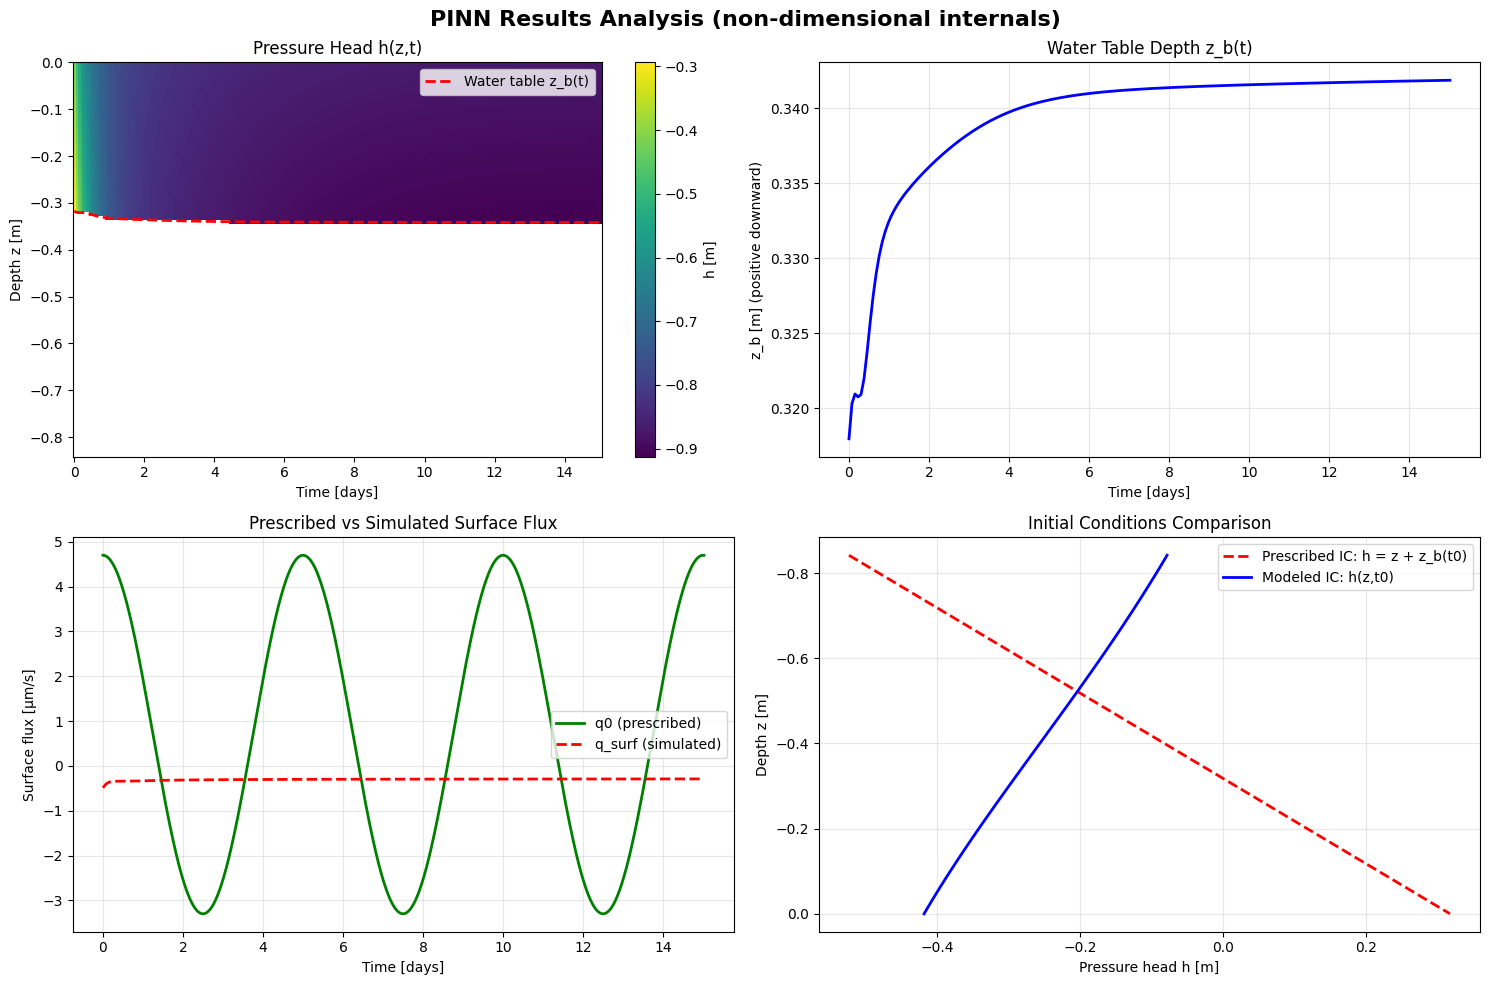


Summary Statistics:
Water table depth range: 0.318 to 0.342 m
Surface head range: -0.873 to -0.419 m
Max IC error: 0.736651 m


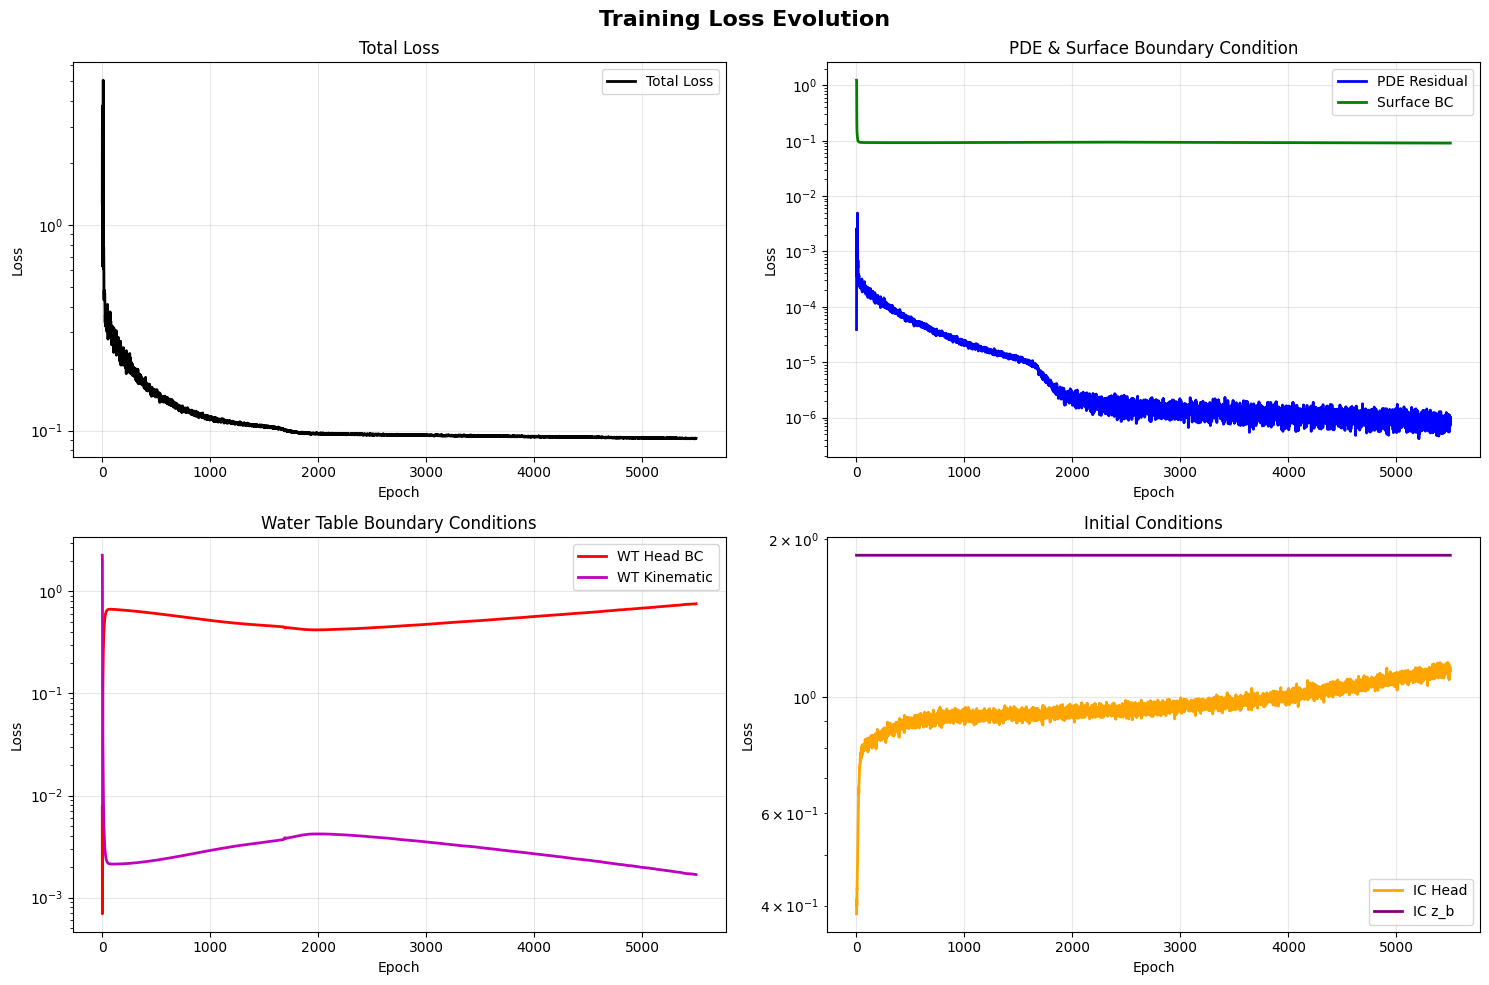

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt


def plot_comprehensive_results(model, q0_data, soil_params, n_t=200, n_z=100):
    """
    Visualization for NON-DIM model (internals are starred).
    Shows:
      (1) h(z,t) colormap [m] in unsat zone,
      (2) z_b(t) [m],
      (3) prescribed q0 vs simulated surface flux [μm/s],
      (4) Initial-condition check at t = min(q0_data time).
    """
    model.eval()
    dev = model.Sy.device

    # --- time range from q0_data (DIMENSIONAL seconds) ---
    t_min_s, t_max_s = float(min(q0_data[0])), float(max(q0_data[0]))

    # time grids
    t_lin_s = torch.linspace(t_min_s, t_max_s, n_t, device=dev)
    t_lin_star = (t_lin_s / model.T).view(-1, 1)
    t_lin_days = t_lin_s.detach().cpu().numpy() / 86400.0

    # --- water table: zb = L * zb*(t*) ---
    with torch.no_grad():
        zb_star_vals = model.zb_net(t_lin_star).cpu().numpy().flatten()
    zb_vals = model.L * zb_star_vals  # meters

    # --- adaptive z-grid in meters (based on deepest water table) ---
    z_min = -float(np.max(zb_vals)) - 0.5  # buffer
    z_max = 0.0
    z_lin_m = torch.linspace(z_min, z_max, n_z, device=dev)

    # mesh in dimensional units (for masking/labels)
    Tm, Zm = torch.meshgrid(t_lin_s, z_lin_m, indexing="ij")
    Tm_np = Tm.detach().cpu().numpy()
    Zm_np = Zm.detach().cpu().numpy()

    # --- compute h*(z*, t*), then dimensional h = H * h* ---
    z_star_flat = (Zm / model.L).reshape(-1, 1)
    t_star_flat = (Tm / model.T).reshape(-1, 1)
    with torch.no_grad():
        h_star_flat = model.forward_star(z_star_flat, t_star_flat)[0]  # (n_t*n_z, 1)
    H_grid = (
        (model.H * h_star_flat).reshape(Tm.shape[0], Zm.shape[1]).cpu().numpy()
    )  # meters

    # mask below the water table (z < -zb(t))
    H_masked = H_grid.copy()
    for i, zb in enumerate(zb_vals):
        mask = Zm_np[i, :] < -zb
        H_masked[i, mask] = np.nan

    # --- surface head h(0,t) (meters) ---
    z_surface_star = torch.zeros_like(t_lin_star, device=dev)
    with torch.no_grad():
        h_surf_star = model.forward_star(z_surface_star, t_lin_star)[0]
    h_surface = (model.H * h_surf_star).cpu().numpy().flatten()

    # --- IC curves at t = t_min ---
    t_ic_s = torch.tensor([t_min_s], device=dev).view(-1, 1)
    t_ic_star = t_ic_s / model.T
    z_ic_m = torch.linspace(z_min, z_max, 50, device=dev).view(-1, 1)
    z_ic_star = z_ic_m / model.L

    with torch.no_grad():
        zb_ic_star = model.zb_net(t_ic_star).cpu().numpy().item()
    zb_ic_m = model.L * zb_ic_star
    h_ic_prescribed = z_ic_m.cpu().numpy().flatten() + zb_ic_m  # meters

    with torch.no_grad():
        h_ic_star_modeled = model.forward_star(
            z_ic_star, t_ic_star.expand_as(z_ic_star)
        )[0]
    h_ic_modeled = (model.H * h_ic_star_modeled).cpu().numpy().flatten()

    # --- surface flux: q = Ks * q*,  q* = -K~(1 + λ ∂h*/∂z*) at z*=0 ---
    z_surf_star = torch.zeros((n_t, 1), device=dev, requires_grad=True)
    t_surf_star = (t_lin_s.view(-1, 1) / model.T).requires_grad_(True)
    h_surf_star, _ = model.forward_star(z_surf_star, t_surf_star)
    dhdz_star = torch.autograd.grad(h_surf_star.sum(), z_surf_star, create_graph=True)[
        0
    ]
    Ktilde = model.soil_star.Ktilde(h_surf_star)
    q_surf_star = -Ktilde * (1.0 + model.lambda_ * dhdz_star)
    q_surf_simulated = (model.Ks * q_surf_star).detach().cpu().numpy().flatten()

    # prescribed q0(t) (seconds -> days for x-axis; μm/s for y-axis)
    q0_t_days = np.asarray(q0_data[0], dtype=float) / 86400.0
    q0_vals = np.asarray(q0_data[1], dtype=float)

    # ----------------- plotting -----------------
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(
        "PINN Results Analysis (non-dimensional internals)",
        fontsize=16,
        fontweight="bold",
    )

    # 1) h(z,t) colormap
    im1 = axs[0, 0].pcolormesh(
        Tm_np / 86400.0, Zm_np, H_masked, shading="auto", cmap="viridis"
    )
    axs[0, 0].plot(t_lin_days, -zb_vals, "r--", lw=2, label="Water table z_b(t)")
    axs[0, 0].set_title("Pressure Head h(z,t)")
    axs[0, 0].set_xlabel("Time [days]")
    axs[0, 0].set_ylabel("Depth z [m]")
    axs[0, 0].set_ylim(z_min, 0)
    axs[0, 0].legend()
    plt.colorbar(im1, ax=axs[0, 0], label="h [m]")

    # 2) zb(t)
    axs[0, 1].plot(t_lin_days, zb_vals, "b-", lw=2)
    axs[0, 1].set_title("Water Table Depth z_b(t)")
    axs[0, 1].set_xlabel("Time [days]")
    axs[0, 1].set_ylabel("z_b [m] (positive downward)")
    axs[0, 1].grid(True, alpha=0.3)

    # 3) surface flux comparison
    axs[1, 0].plot(q0_t_days, q0_vals * 1e6, "g-", lw=2, label="q0 (prescribed)")
    axs[1, 0].plot(
        t_lin_days, q_surf_simulated * 1e6, "r--", lw=2, label="q_surf (simulated)"
    )
    axs[1, 0].set_xlabel("Time [days]")
    axs[1, 0].set_ylabel("Surface flux [μm/s]")
    axs[1, 0].set_title("Prescribed vs Simulated Surface Flux")
    axs[1, 0].grid(True, alpha=0.3)
    axs[1, 0].legend()

    # 4) Initial conditions comparison
    axs[1, 1].plot(
        h_ic_prescribed,
        z_ic_m.cpu().numpy().flatten(),
        "r--",
        lw=2,
        label="Prescribed IC: h = z + z_b(t0)",
    )
    axs[1, 1].plot(
        h_ic_modeled,
        z_ic_m.cpu().numpy().flatten(),
        "b-",
        lw=2,
        label="Modeled IC: h(z,t0)",
    )
    axs[1, 1].set_title("Initial Conditions Comparison")
    axs[1, 1].set_xlabel("Pressure head h [m]")
    axs[1, 1].set_ylabel("Depth z [m]")
    axs[1, 1].legend()
    axs[1, 1].grid(True, alpha=0.3)
    axs[1, 1].invert_yaxis()

    plt.tight_layout()
    plt.show()

    # summaries
    print(f"\nSummary Statistics:")
    print(f"Water table depth range: {zb_vals.min():.3f} to {zb_vals.max():.3f} m")
    print(f"Surface head range: {h_surface.min():.3f} to {h_surface.max():.3f} m")
    print(f"Max IC error: {np.max(np.abs(h_ic_modeled - h_ic_prescribed)):.6f} m")


def plot_training_losses(losses, comps, log_scale=True):
    """
    Plot training loss evolution with all components.
    """
    epochs = range(1, len(losses) + 1)

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Training Loss Evolution", fontsize=16, fontweight="bold")

    # Total loss
    axs[0, 0].plot(epochs, losses, "k-", lw=2, label="Total Loss")
    axs[0, 0].set_title("Total Loss")
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Loss")
    if log_scale:
        axs[0, 0].set_yscale("log")
    axs[0, 0].grid(True, alpha=0.3)
    axs[0, 0].legend()

    # PDE & Surface BC
    axs[0, 1].plot(epochs, comps["pde"], "b-", lw=2, label="PDE Residual")
    axs[0, 1].plot(epochs, comps["surf"], "g-", lw=2, label="Surface BC")
    axs[0, 1].set_title("PDE & Surface Boundary Condition")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Loss")
    if log_scale:
        axs[0, 1].set_yscale("log")
    axs[0, 1].grid(True, alpha=0.3)
    axs[0, 1].legend()

    # WT losses
    axs[1, 0].plot(epochs, comps["wt_head"], "r-", lw=2, label="WT Head BC")
    axs[1, 0].plot(epochs, comps["wt_kin"], "m-", lw=2, label="WT Kinematic")
    axs[1, 0].set_title("Water Table Boundary Conditions")
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Loss")
    if log_scale:
        axs[1, 0].set_yscale("log")
    axs[1, 0].grid(True, alpha=0.3)
    axs[1, 0].legend()

    # IC losses
    axs[1, 1].plot(epochs, comps["ic_h"], "orange", lw=2, label="IC Head")
    axs[1, 1].plot(epochs, comps["ic_zb"], "purple", lw=2, label="IC z_b")
    axs[1, 1].set_title("Initial Conditions")
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Loss")
    if log_scale:
        axs[1, 1].set_yscale("log")
    axs[1, 1].grid(True, alpha=0.3)
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


# After training has finished, you should already have:
# model, losses, comps
# q0_data_sin  -> (times_in_seconds, flux_in_m_per_s)
# soil_params  -> same dict you used for training

# (Optional) quick sanity check of scales & units
print(f"L = {model.L:.3f} m, H = {model.H:.3f} m, T = {model.T / 86400:.2f} days")
print("Example q0 times (s):", q0_data_sin[0][:3])
print("Example q0 flux (m/s):", q0_data_sin[1][:3])

# 1) Comprehensive results figure
plot_comprehensive_results(model, q0_data_sin, soil_params, n_t=200, n_z=100)

# 2) Training loss curves
plot_training_losses(losses, comps, log_scale=True)
